Here I investigate the number of significant associations present across different patch sizes.

In [3]:
import os
import sys
sys.path = ['/nfs/gns/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages'] + sys.path
GTEx_directory = '/hps/nobackup/research/stegle/users/willj/GTEx'
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
import h5py
from scipy.stats import pearsonr
import statsmodels.stats.multitest as smm
import seaborn

In [4]:
with h5py.File(GTEx_directory + '/data/retrained_inceptionet_aggregations.hdf5','r') as f:
    expression = f['lung']['256']['expression'].value
    mean_features = f['lung']['256']['mean'].value
    expression_IDs = f['lung']['256']['expression_IDs'].value

# Most features don't vary

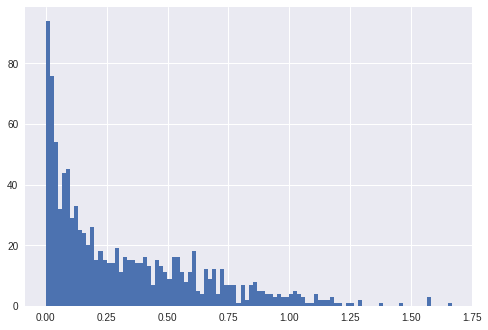

In [65]:
plt.hist(np.std(mean_features,axis=0),bins=100)
plt.show()

# Most transcripts do not vary across samples

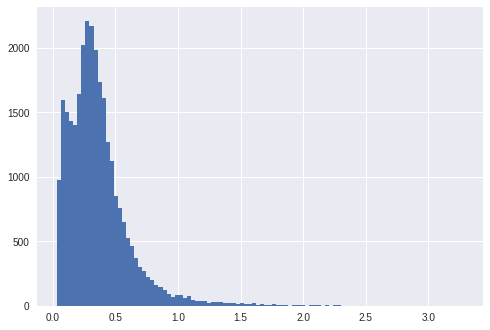

In [64]:
plt.hist(np.std(expression,axis=0),bins=100)
plt.show()

# Choose 500 most varying features. Choose 10000 most varying genes

In [7]:
most_expressed_transcript_idx = np.argsort(np.std(expression,axis=0))[::-1]
most_expressed_feature_idx = np.argsort(np.std(mean_features,axis=0))[::-1]

In [8]:
filt_expression = expression[:,most_expressed_transcript_idx[:5000]]
filt_mean_features = mean_features[:,most_expressed_feature_idx[:100]]

Note miniumum values with respect to the distributions

In [9]:
print (min(np.std(filt_expression,axis=0)))
print (min(np.std(filt_mean_features,axis=0)))

0.526415
0.703491


# Calculate associations

In [11]:
min(associations.flatten())

5.3769453145902996e-42

In [10]:
N = 100
M = 5000
associations = np.zeros((N,M))
R_matrix = np.zeros((N,M))
for i in range(N):
    if i % 10 == 0 :
        print (i)
    for j in range(M):
        res = pearsonr(filt_expression[:,j], filt_mean_features[:,i])
        R_matrix[i,j] = res[0]
        associations[i,j] = res[1]
        

0
10
20
30
40
50
60
70
80
90


# Raw number of associations for changing FDRs

In [24]:
alphas=[0.01,0.001,0.0001,0.00001,0.000001]
[sum(smm.multipletests(associations.flatten(),alpha=a)[0]) for a in alphas]


[57929, 46104, 36780, 29238, 23180]

# Compare across patch sizes and aggregations methods

In [27]:
results = {}
aggregations = ['mean','median']
sizes = ['128','256','512','1024','2048']    
for a in aggregations:
    for s in sizes:
        print (a,s)
        with h5py.File(GTEx_directory + '/data/retrained_inceptionet_aggregations.hdf5','r') as f:
            expression = f['lung'][s]['expression'].value
            mean_features = f['lung'][s][a].value
            expression_IDs = f['lung'][s]['expression_IDs'].value
            most_expressed_transcript_idx = np.argsort(np.std(expression,axis=0))[::-1]
            most_expressed_feature_idx = np.argsort(np.std(mean_features,axis=0))[::-1]
            filt_expression = expression[:,most_expressed_transcript_idx[:5000]]
            filt_mean_features = mean_features[:,most_expressed_feature_idx[:100]]
            
            N = 100
            M = 5000
            pvalues = np.zeros((N,M))
            R_matrix = np.zeros((N,M))
            for i in range(N):
                for j in range(M):
                    res = pearsonr(filt_expression[:,j], filt_mean_features[:,i])
                    R_matrix[i,j] = res[0]
                    pvalues[i,j] = res[1]
            
            R_key = '{}_{}_{}'.format(a,s,'pvalues')
            assoc_key = '{}_{}_{}'.format(a,s,'R')
            results[R_key] = R_matrix
            results[assoc_key] = pvalues
            
            
        

mean 128
mean 256
mean 512
mean 1024
mean 2048
median 128
median 256
median 512
median 1024
median 2048


# Plot raw number of associations as a function of aggregation method and patch size

## Interestingly, there seems to be a maximum at patch size 256

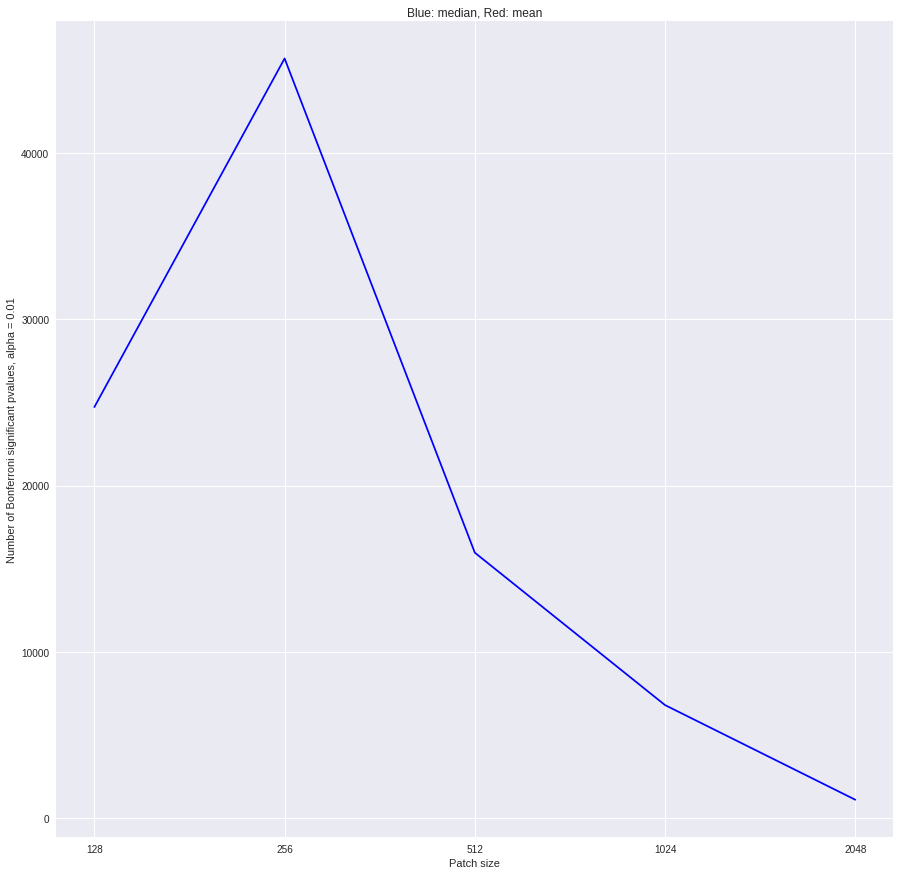

In [63]:
plt.figure(figsize=(15,15))
plt.title("Blue: median, Red: mean")
plt.xticks(range(len(alphas)),sizes)
plt.xlabel('Patch size')
plt.ylabel('Number of Bonferroni significant pvalues, alpha = 0.01')
for a in aggregations[0:1]:
    points = [sum(smm.multipletests(results['{}_{}_{}'.format(a,s,'R')].flatten(),method='bonferroni',alpha=0.001)[0]) for s in sizes]
    plt.plot(points, c='blue')

mean_128_R
mean_256_R
mean_512_R
mean_1024_R
mean_2048_R


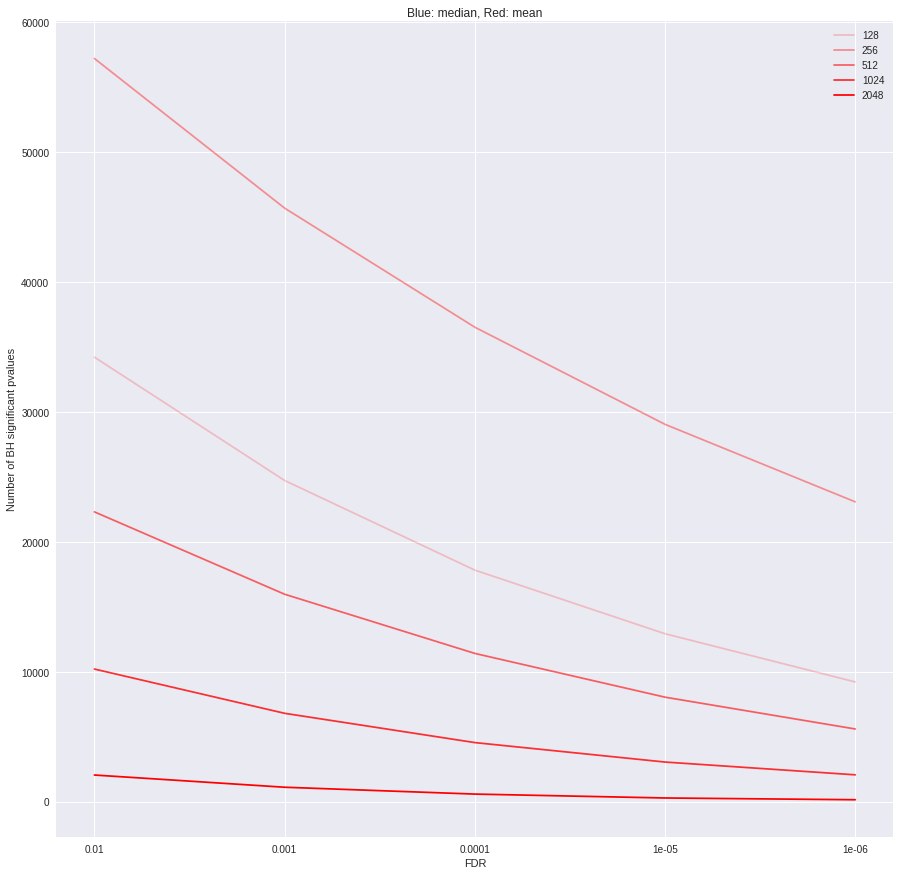

In [66]:

plt.figure(figsize=(15,15))
plt.title("Blue: median, Red: mean")
alphas=[0.01,0.001,0.0001,0.00001,0.000001]
plt.xticks(range(len(alphas)),alphas)
plt.xlabel('FDR')
plt.ylabel('Number of BH significant pvalues')
for a in aggregations[0:1]:
    for (k,s) in enumerate(sizes):
        if a == 'mean':
            c = 'red'
        else:
            c = 'blue'
            
        assoc_key = '{}_{}_{}'.format(a,s,'R')
        print (assoc_key)
        associations = results[assoc_key]
        
        points = [sum(smm.multipletests(associations.flatten(),method='bonferroni',alpha=a)[0]) for a in alphas]
        plt.plot(points, c=c,label=s,alpha=0.2 + 0.2*k)
plt.legend()

        

# Comparing mean / median

## More associations using mean apart from at very large patch sizes.

mean_128_R
mean_256_R
mean_512_R
mean_1024_R
mean_2048_R
median_128_R
median_256_R
median_512_R
median_1024_R
median_2048_R


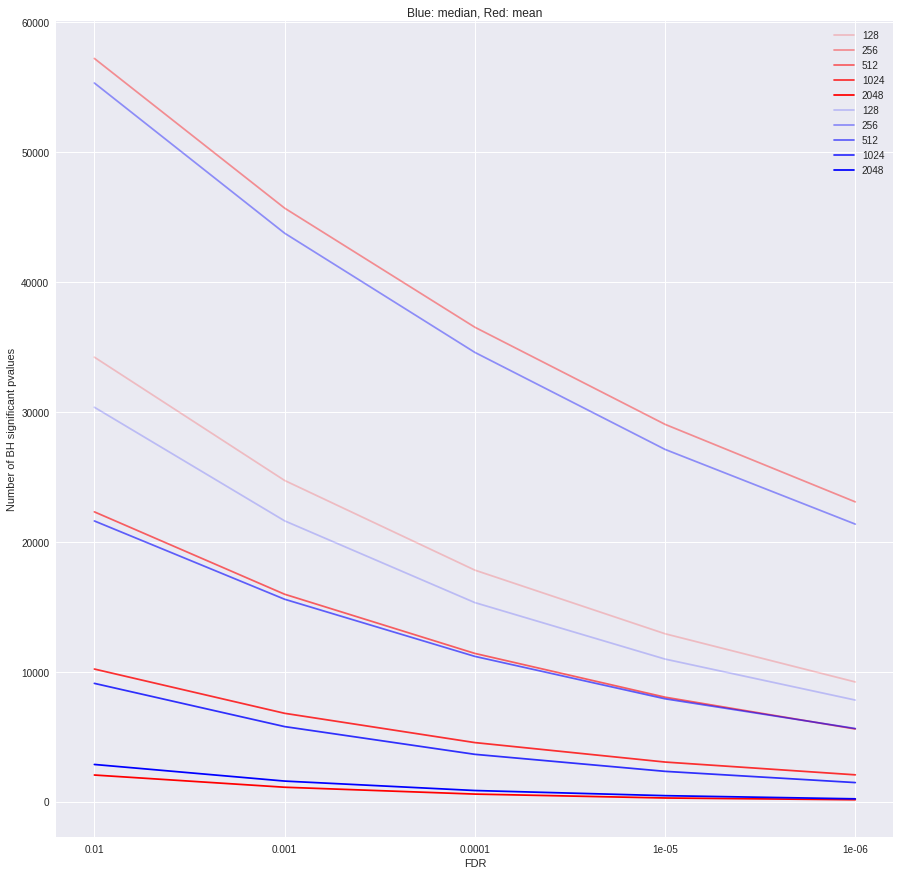

In [67]:

plt.figure(figsize=(15,15))
plt.title("Blue: median, Red: mean")
alphas=[0.01,0.001,0.0001,0.00001,0.000001]
plt.xticks(range(len(alphas)),alphas)
plt.xlabel('FDR')
plt.ylabel('Number of BH significant pvalues')
for a in aggregations:
    for (k,s) in enumerate(sizes):
        if a == 'mean':
            c = 'red'
        else:
            c = 'blue'
            
        assoc_key = '{}_{}_{}'.format(a,s,'R')
        print (assoc_key)
        associations = results[assoc_key]
        
        points = [sum(smm.multipletests(associations.flatten(),method='bonferroni',alpha=a)[0]) for a in alphas]
        plt.plot(points, c=c,label=s,alpha=0.2 + 0.2*k)
plt.legend()

        